In [42]:
import datetime
import logging
import typing as t
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import semver
from tqdm.notebook import tqdm

import ssvr.enrich_trials
import ssvr.qc
import ssvr.utils

%load_ext autoreload
%autoreload 2
from ssvr.dataset import SessionDataset, find_session_info
from ssvr.models import DataLoadingSettings, SessionInfo

logging.getLogger("ssvr").setLevel(logging.ERROR)

logging.getLogger("aind_behavior_services.base").setLevel(logging.ERROR)

choice_linestyle = {True: "-", False: "--"}
subject_colors = {"808619": "C2", "808728": "C3", "789917": "C4"}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
settings = DataLoadingSettings()
session_info = list(find_session_info(settings))
session_info = [session for session in session_info if session.version >= semver.Version.parse("0.6.0")]
session_datasets: list[SessionDataset] = []

session_filter = pd.read_csv(Path(settings.root_path[0]) / "../sessions.csv")
session_filter["use"] = session_filter["use"].apply(lambda x: x == "1" if pd.notna(x) else False)
session_filter["crop_trial"] = pd.to_numeric(session_filter["crop_trial"], errors="coerce").astype("Int64")


def _use_session(session: SessionInfo) -> bool:
    session_name = session.session_id
    if session_name not in session_filter["session"].values:
        return False
    return session_filter[session_filter["session"] == session_name]["use"].iloc[0]


session_datasets = []
for info in tqdm(session_info, desc="Loading sessions"):
    if _use_session(info):
        try:
            _session = SessionDataset(session_info=info, processing_settings=settings.processing_settings)
            row = session_filter[session_filter["session"] == info.session_id].iloc[0]
            if not _session.session_metrics.session_duration < datetime.timedelta(minutes=15):
                if pd.notna(row["crop_trial"]):
                    _session.trials = _session.trials[: int(row["crop_trial"])]
                session_datasets.append(_session)
        except Exception as e:
            print(f"Failed to load session {info.session_id}: {e}")

for session in tqdm(session_datasets, desc="Enriching sessions"):
    enriched_trials = ssvr.enrich_trials.enrich_with_block_info(session)
    enriched_trials = ssvr.enrich_trials.enrich_with_relative_to_block(session)
    enriched_trials = ssvr.enrich_trials.enrich_with_previous_trial(session, n_previous=5)

if 0:
    ssvr.qc.run_qc(session_datasets=session_datasets, path=Path("./derived") / "qc_reports")

Loading sessions:   0%|          | 0/92 [00:00<?, ?it/s]

Enriching sessions:   0%|          | 0/64 [00:00<?, ?it/s]

In [5]:
all_trials = []
for session in session_datasets:
    df = session.trials.copy()
    df = df.reset_index().rename(columns={"index": "trial_number"})
    df["subject"] = session.session_info.subject
    df["session_id"] = session.session_info.session_id
    all_trials.append(df)

all_trials_df = t.cast(pd.DataFrame, pd.concat(all_trials, ignore_index=True))
# all_trials_df.to_csv(Path("./derived") / "all_sessions_enriched_trials.csv")
print(all_trials_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16745 entries, 0 to 16744
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   trial_number                          16745 non-null  int64  
 1   odor_onset_time                       16745 non-null  float64
 2   choice_time                           9293 non-null   float64
 3   reward_time                           6604 non-null   float64
 4   reaction_duration                     9293 non-null   float64
 5   patch_index                           16745 non-null  int64  
 6   is_rewarded                           16378 non-null  object 
 7   is_choice                             16745 non-null  bool   
 8   p_reward                              16378 non-null  float64
 9   stop_time                             9293 non-null   float64
 10  longest_stop_duration                 13833 non-null  float64
 11  block          

In [46]:
# X axis is trials to block switch
# Y axis is probability of choice
# we only want switches where the probabilities actually switched
import numpy as np

block_switch_filter: t.Literal["same", "different", "both"] = "different"

block_switches = (
    all_trials_df["block_index"].diff().fillna(0) > 0
)  # this also gets rid of cross session switches since those diffs will be <=0
switch_indices = all_trials_df.index[block_switches]
all_trials_df.sort_index(inplace=True)  # just to ensure the shift works correctly
block_probabilities_before = all_trials_df["block_patch_probabilities"].shift()[block_switches]
block_probabilities_after = all_trials_df["block_patch_probabilities"][block_switches]
prob_switch_df = pd.DataFrame(
    {
        "before": block_probabilities_before.values,
        "after": block_probabilities_after.values,
        "before_high_index": [np.argmax(probs) for probs in block_probabilities_before.values],
        "after_high_index": [np.argmax(probs) for probs in block_probabilities_after.values],
        "after_low_index": [np.argmin(probs) for probs in block_probabilities_after.values],
        "before_low_index": [np.argmin(probs) for probs in block_probabilities_before.values],
    },
    index=switch_indices,
)

if block_switch_filter == "same":
    prob_switch_df = prob_switch_df[prob_switch_df["before"].apply(tuple) == prob_switch_df["after"].apply(tuple)]
elif block_switch_filter == "different":
    prob_switch_df = prob_switch_df[prob_switch_df["before"].apply(tuple) != prob_switch_df["after"].apply(tuple)]
elif block_switch_filter == "both":
    pass
else:
    raise ValueError(f"Invalid block_switch_filter: {block_switch_filter}")


Processing block switches: 0it [00:00, ?it/s]

10
20
10
0
10
20
10
0
10
20
10
0
10
0
10
20
10
0
10
0
10
20
10
0
8
13
10
0
10
0
9
19
10
0
10
20
10
0
10
0
10
20
10
0
10
20
10
0
10
0
10
20
8
0
10
20
10
0
10
20
10
0
10
20
10
0
8
13
10
0
10
20
10
0
10
20
10
0
8
13
10
0
10
20
10
0
10
20
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
0
10
20
10
0
10
20
8
0
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
20
10
0
10
20
10
0
10
0
10
20
10
0
10
20
10
20
10
0
10
20
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
0
10
20
10
0
10
20
10
0
7
12
10
20
10
0
10
20
7
0
10
0
10
20
10
0
10
0
10
20
10
0
10
20
10
20
10
0
10
0
10
20
10
0
10
17
10
0
10
20
10
20
10
0
10
20
10
0
10
20
10
20
10
0
6
11
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
20
10
0
10
20
10
0
10
20
6
0
10
20
10
0
10
20
10
0
10
20
5
0
10
0
10
20
10
0
10
0
10
20
10
0
10
20
10
0
10
20
10
20
10
0
10
20
10
0
10
0
10
20
10
0
8
18
10
20
10
0
10
20
10
0
10
0
10
20
10
20
10
0
10
20
10
0
10
20
10
0
10
20
10
0
10
0
10

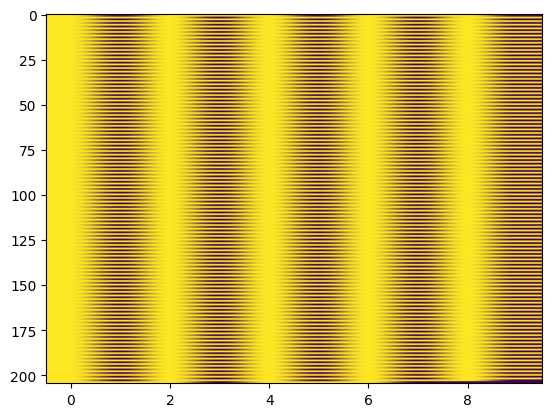

In [ ]:
trial_window = (-5, 5)
unique_patches_id = (0, 1) # high, low

switch_choice_data = np.ndarray(shape=(len(prob_switch_df), trial_window[1] - trial_window[0], 2), dtype=bool)

for i_switch, (trial_switch, row) in tqdm(enumerate(prob_switch_df.iterrows()), desc="Processing block switches"):
    switch_trial = all_trials_df.loc[trial_switch]
    session_id = switch_trial["session_id"]
    session_trials = all_trials_df[all_trials_df["session_id"] == session_id]
    trial_window_mask_after = (session_trials["trials_from_last_block_by_trial_type"] < trial_window[1]) & (session_trials["block_index"] == switch_trial["block_index"])
    trial_window_mask_before = (session_trials["trials_to_next_block_by_trial_type"] < -trial_window[0]) &  (session_trials["block_index"] == switch_trial["block_index"] - 1)
    trial_window_mask = trial_window_mask_after | trial_window_mask_before
    for patch_id in unique_patches_id:
        patch_id_mask = session_trials["patch_index"] == prob_switch_df.loc[trial_switch]["after_high_index"] if patch_id == 0 else prob_switch_df.loc[trial_switch]["after_low_index"]
        trials_to_take = session_trials[trial_window_mask & patch_id_mask]
        #switprintch_choice_data[i_switch, :len(trials_to_take), patch_id] = trials_to_take["is_choice"].values

plt.figure()
plt.imshow(switch_choice_data[:, :, 0], aspect='auto', cmap='viridis')
plt.show()
